<h1>Calculate your own training/validation weights</h1>
We generalise and pythonise the code to calculate the Knn weighting scheme (found in Lima et al). This tutorial shows you how to call it from within your python program.


In [1]:
#put calculate_weights.py in your path
from astropy.table import Table
import numpy as np
import sys

#****************************************************************
#modify this line to point to your useful_tools directory *******
sys.path.append('/Users/hoyleb/Documents/python/modules/photoz-wg/useful_tools/')
#****************************************************************
import lima_knn_weights as cw

#****************************************************************
#modify this line to point to your data directory *******
#where does your data sit?
path = '/Users/hoyleb/DATA/DES/PHOTOZ/'

In [2]:
#load test, xval, train data and turn into an array
trainval_d = Table.read(path + 'sims_spectra_mimic_des.csv.fits')                
test_d = Table.read(path + 'sims_spectra_representative_valid.WL_LSS_FLAGS.fits.gz')

#apply the selection of the WL sample
test_d = test_d[test_d['WL_SAMPLE'] ==1]

#load weighting feature list
weight_f = ['MAG_R', 'MAG_I', 'MAG_G-MAG_R','MAG_R-MAG_I','MAG_I-MAG_Z']

#get training and validation indicies
train = trainval_d['VALID'] == 0
valid = trainval_d['VALID'] == 1

input_trainValid = np.zeros((len(trainval_d), len(weight_f)), dtype=float)
input_test = np.zeros((len(test_d), len(weight_f)), dtype=float)

#get data to determine weights  | your code to turn the above features into an array
for i, ky in enumerate(weight_f):
    if '-' in ky:
        c1, c2 = ky.split('-')
        input_trainValid[:, i] = np.array(trainval_d[c1] - trainval_d[c2])
        input_test[:, i] = np.array(test_d[c1] - test_d[c2])
    else:
        input_trainValid[:, i] = np.array(trainval_d[ky])
        input_test[:, i] = np.array(test_d[ky])


In [3]:
#call the knn weighting codes
weightTrain = cw.lima_knn_weights(input_trainValid[train], input_test, n_neighbors=5)
weightVal = cw.lima_knn_weights(input_trainValid[valid], input_test, n_neighbors=5)

#weightTrain  <-- these are your training weights
#weightVal  <-- these are your validation weights

#compare with weights from Chris in the file
WL_train_weights = trainval_d['WL_train_weights'][train]
WL_valid_weights = trainval_d['WL_valid_weights'][valid]


<h2>Stop! you are done :)</h2>
The rest is just plotting and seeing how well (visually) we did.

In [4]:
#how well did we do?
%matplotlib inline
import matplotlib.pyplot as plt
from weighted_kde import gaussian_kde as gss_kde
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 32,
                    'ytick.labelsize': 32})

Nwghts = len(weight_f)
axis_rng = [np.linspace(np.amin([np.amin(input_test[:, i]), np.amin(input_trainValid[:,i])]), 
                        np.amax([np.amax(input_test[:, i]), np.amax(input_trainValid[:,i])]), 1000) 
            for i in range(Nwghts)]

In [5]:
test_kde = [gss_kde(input_test[:, i]).evaluate(axis_rng[i]) for i in range(Nwghts)]
train_kde =  [gss_kde(input_trainValid[train, i], weights=weightTrain).evaluate(axis_rng[i]) for i in range(Nwghts)]
valid_kde =  [gss_kde(input_trainValid[valid, i], weights=weightVal).evaluate(axis_rng[i]) for i in range(Nwghts)]

train1_kde =  [gss_kde(input_trainValid[train, i], weights=WL_train_weights).evaluate(axis_rng[i]) for i in range(Nwghts)]
valid1_kde =  [gss_kde(input_trainValid[valid, i], weights=WL_valid_weights).evaluate(axis_rng[i]) for i in range(Nwghts)]


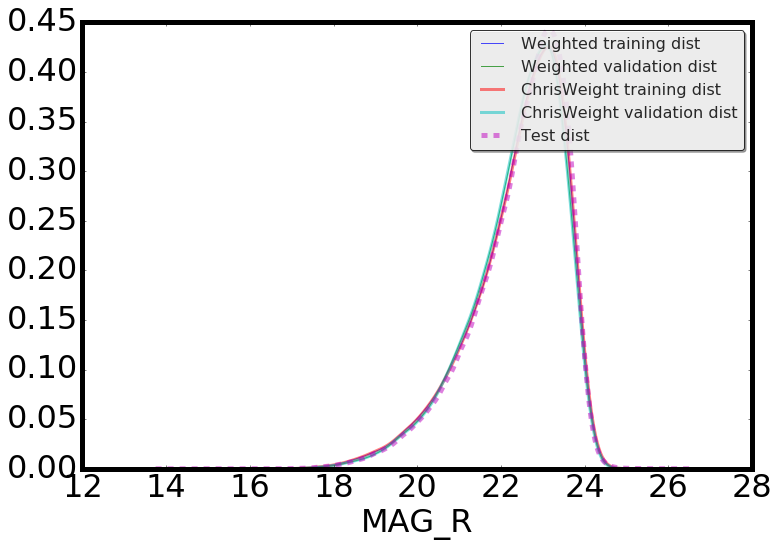

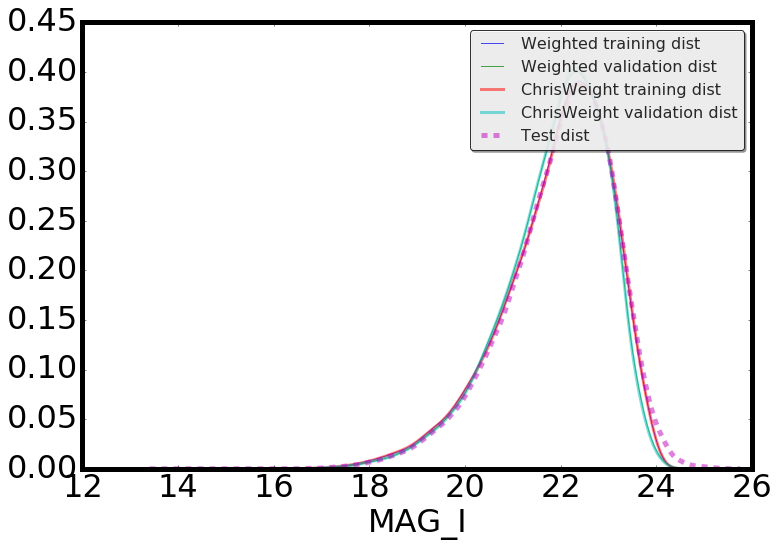

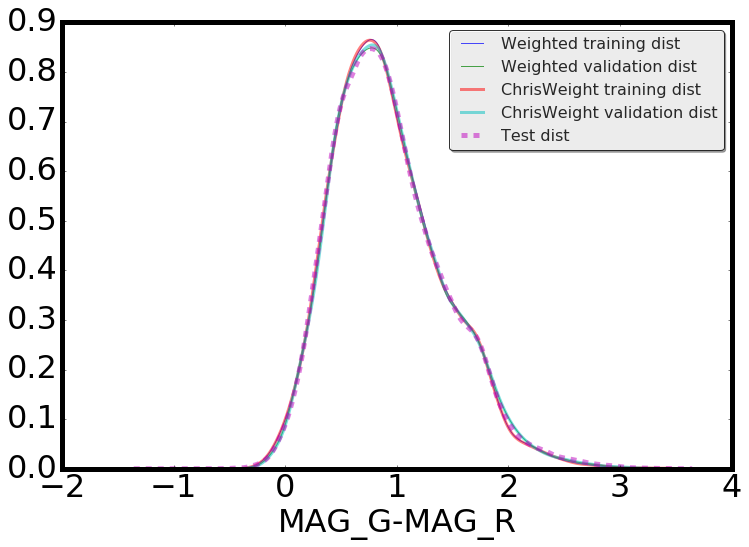

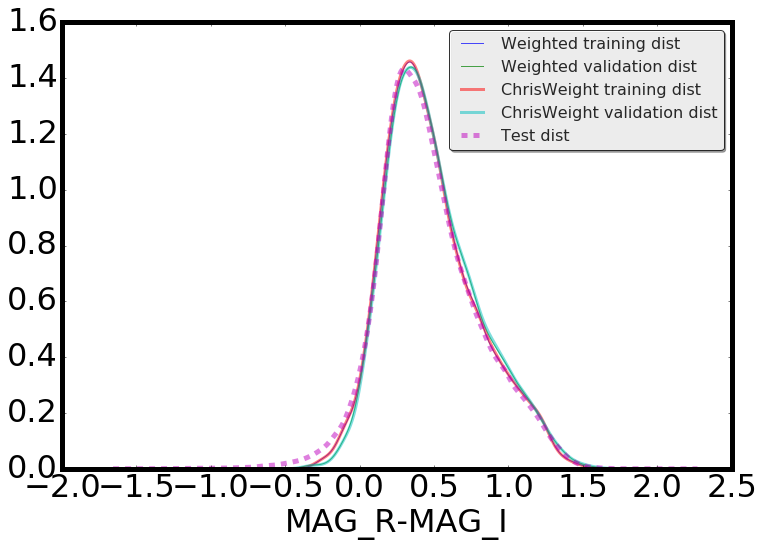

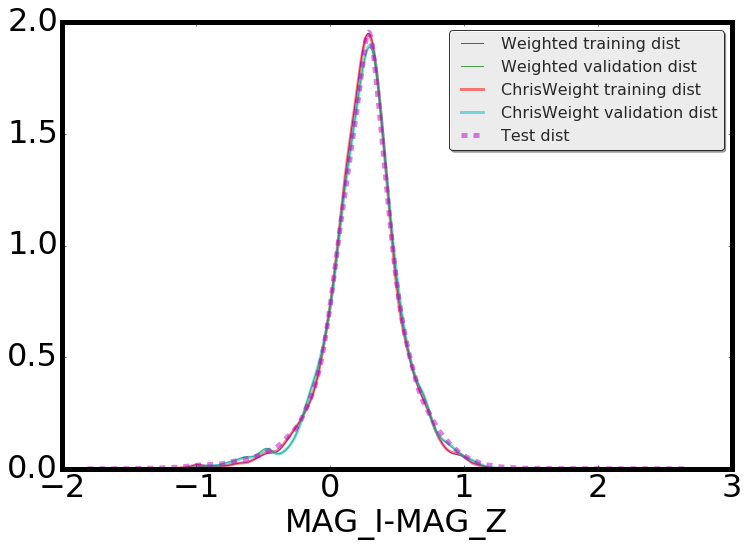

In [6]:

for i, ky in enumerate(weight_f):
    f = plt.figure()
    plt.xlabel(ky)
    
    plt.plot(axis_rng[i], train_kde[i], label='Weighted training dist',alpha=0.7)
    plt.plot(axis_rng[i], valid_kde[i], label='Weighted validation dist',alpha=0.7)
    
    plt.plot(axis_rng[i], train1_kde[i], label='ChrisWeight training dist', alpha=0.5,linewidth=3)
    plt.plot(axis_rng[i], valid1_kde[i], label='ChrisWeight validation dist', alpha=0.5,linewidth=3)
    plt.plot(axis_rng[i], test_kde[i],'--', label='Test dist',alpha=0.5 ,linewidth=5)
    plt.legend(loc=1)